# Предобработка данных

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.simplefilter("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

## Специфические преобразования

In [2]:
# Загрузим набор данных

df = pd.read_csv('freMPL-R.csv', low_memory=False)
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

В предыдущем уроке мы заметили отрицательную величину убытка для некоторых наблюдений. Заметим, что для всех таких полисов переменная "ClaimInd" принимает только значение 0. Поэтому заменим все соответствующие значения "ClaimAmount" нулями.

In [3]:
NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
NegClaimAmount.head()

Unique values of ClaimInd: [0]


,ClaimAmount,ClaimInd
82,-74.206042,0
175,-1222.585196,0
177,-316.288822,0
363,-666.758610,0
375,-1201.600604,0


In [4]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

Для моделирования частоты убытков сгенерируем показатель как сумму индикатора того, что убыток произошел ("ClaimInd") и количества заявленных убытков по различным видам ущерба за 4 предшествующих года ("ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen").

В случаях, если соответствующая величина убытка равняется нулю, сгенерированную частоту также обнулим.

In [5]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [6]:
pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)

,Policies
0.0,104286
2.0,3529
1.0,3339
3.0,2310
4.0,1101
5.0,428
6.0,127
7.0,26
8.0,6
9.0,2


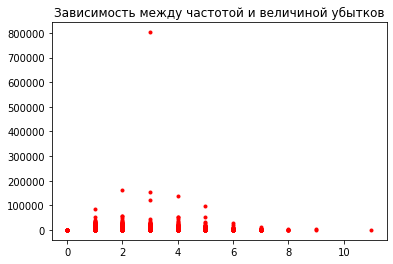

In [7]:

import seaborn as sns
plt.plot(df['ClaimsCount'],df['ClaimAmount'], '.r')
plt.title('Зависимость между частотой и величиной убытков')
plt.show()

Для моделирования среднего убытка можем рассчитать его как отношение величины убытков к их частоте.

In [8]:
df.loc[df.ClaimsCount > 0, 'AvgClaim'] = df['ClaimAmount']/df['ClaimsCount']

## Общие преобразования

Класс для общих случаев

In [9]:
class InsDataFrame:


    ''' Load data method '''

    def load_pd(self, pd_dataframe):
        self._df = pd_dataframe


    ''' Columns match method '''

    def columns_match(self, match_from_to):
        self._df.rename(columns=match_from_to, inplace=True)


    ''' Person data methods '''

    # Gender
    _gender_dict = {'Male':0, 'Female':1}

    def transform_gender(self):
        self._df['Gender'] = self._df['Gender'].map(self._gender_dict)

        

    # Age
    @staticmethod
    def _age(age, age_max):
        if pd.isnull(age):
            age = None
        elif age < 18:
            age = None
        elif age > age_max:
            age = age_max
        return age
      
    def transform_age(self, age_max=70):
        self._df['driver_minage'] = self._df['driver_minage'].apply(self._age, args=(age_max,))

    # Age M/F
    @staticmethod
    def _age_gender(age_gender):
        _age = age_gender[0]
        _gender = age_gender[1]
        if _gender == 0: #Male
            _driver_minage_m = _age
            _driver_minage_f = 18
        elif _gender == 1: #Female
            _driver_minage_m = 18
            _driver_minage_f = _age
        else:
            _driver_minage_m = 18
            _driver_minage_f = 18
        return [_driver_minage_m, _driver_minage_f]
    
    def transform_age_gender(self):
        self._df['driver_minage_m'],self._df['driver_minage_f'] = zip(*self._df[['driver_minage','Gender']].apply(self._age_gender, axis=1).to_frame()[0])

    # Experience
    @staticmethod
    def _exp(exp, exp_max):
        if pd.isnull(exp):
            exp = None
        elif exp < 0:
            exp = None
        elif exp > exp_max:
            exp = exp_max
        return exp

    def transform_exp(self, exp_max=52):
        self._df['driver_minexp'] = self._df['driver_minexp'].apply(self._exp, args=(exp_max,))


    ''' Other data methods '''

    def polynomizer(self, column, n=2):
        if column in list(self._df.columns):
            for i in range(2,n+1):
                self._df[column+'_'+str(i)] = self._df[column]**i

    def get_dummies(self, columns):
        self._df = pd.get_dummies(self._df, columns=columns)


    ''' General methods '''

    def info(self):
        return self._df.info()

    def head(self, columns, n=5):
        return self._df.head(n)

    def len(self):
        return len(self._df)

    def get_pd(self, columns):
        return self._df[columns]

Создаем класс-наследник, в котором переопределяем некоторые методы, специфические для конкретной ситуации, и создаем новые

- В данных стаж "LicAge" измеряется в неделях.
- Фактор "SocioCateg" содержит информацию о социальной категории в виде кодов классификации CSP. Агрегируем имеющиеся коды до 1 знака, а затем закодируем их с помощью one-hot encoding.

[Wiki](https://fr.wikipedia.org/wiki/Professions_et_cat%C3%A9gories_socioprofessionnelles_en_France#Cr%C3%A9ation_de_la_nomenclature_des_PCS)

[Более подробный классификатор](https://www.ast74.fr/upload/administratif/liste-des-codes-csp-copie.pdf)

In [10]:
class InsDataFrame_Fr(InsDataFrame):

    # Experience (weeks to years)
    @staticmethod
    def _exp(exp, exp_max):
        if pd.isnull(exp):
            exp = None
        elif exp < 0:
            exp = None
        else:
            exp * 7 // 365
        if exp > exp_max:
            exp = exp_max
        return exp

    # Marital status
    _MariStat_dict = {'Other':0, 'Alone':1}

    def transform_MariStat(self):
        self._df['MariStat'] = self._df['MariStat'].map(self._MariStat_dict)
    
    # Social category
    def transform_SocioCateg(self):
        self._df['SocioCateg'] = self._df['SocioCateg'].str.slice(0,4)

Подгружаем данные

In [11]:
data = InsDataFrame_Fr()

In [12]:
data.load_pd(df)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Exposure     115155 non-null  float64
 1   LicAge       115155 non-null  int64  
 2   RecordBeg    115155 non-null  object 
 3   RecordEnd    59455 non-null   object 
 4   Gender       115155 non-null  object 
 5   MariStat     115155 non-null  object 
 6   SocioCateg   115155 non-null  object 
 7   VehUsage     115155 non-null  object 
 8   DrivAge      115155 non-null  int64  
 9   HasKmLimit   115155 non-null  int64  
 10  BonusMalus   115155 non-null  int64  
 11  ClaimAmount  115155 non-null  float64
 12  ClaimInd     115155 non-null  int64  
 13  OutUseNb     115155 non-null  float64
 14  RiskArea     115155 non-null  float64
 15  ClaimsCount  115155 non-null  float64
 16  AvgClaim     10869 non-null   float64
dtypes: float64(6), int64(5), object(6)
memory usage: 14.9+ MB


Преобразовываем параметры

In [14]:
# Переименовываем
data.columns_match({'DrivAge':'driver_minage','LicAge':'driver_minexp'})

In [15]:
# Преобразовываем
data.transform_age()
data.transform_exp()
data.transform_gender()
data.transform_MariStat()
data.transform_SocioCateg()

In [16]:
# Пересечение пола и возраста, их квадраты
data.transform_age_gender()
data.polynomizer('driver_minage_m')
data.polynomizer('driver_minage_f')

Для переменных, содержащих более 2 значений:
- либо упорядочиваем значения,
- либо используем фиктивные переменные (one-hot encoding).

**NB**: В H2O не рекомендуется использовать one-hot encoding. Тем не менее, используем здесь фиктивные переменные, чтобы в дальнейшем сохранить возможность сравнения результатов построенных моделей.

In [17]:
# Onehot encoding
data.get_dummies(['VehUsage','SocioCateg'])

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 30 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Exposure                         115155 non-null  float64
 1   driver_minexp                    115155 non-null  int64  
 2   RecordBeg                        115155 non-null  object 
 3   RecordEnd                        59455 non-null   object 
 4   Gender                           115155 non-null  int64  
 5   MariStat                         115155 non-null  int64  
 6   driver_minage                    115155 non-null  int64  
 7   HasKmLimit                       115155 non-null  int64  
 8   BonusMalus                       115155 non-null  int64  
 9   ClaimAmount                      115155 non-null  float64
 10  ClaimInd                         115155 non-null  int64  
 11  OutUseNb                         115155 non-null  float64
 12  Ri

In [19]:
col_features = [
                'driver_minexp',
                'Gender',
                'MariStat',
                'HasKmLimit',
                'BonusMalus',
                'OutUseNb',
                'RiskArea',
                'driver_minage_m',
                'driver_minage_f',
                'driver_minage_m_2',
                'driver_minage_f_2',
                'VehUsage_Private',
                'VehUsage_Private+trip to office',
                'VehUsage_Professional',
                'VehUsage_Professional run',
                'SocioCateg_CSP1',
                'SocioCateg_CSP2',
                'SocioCateg_CSP3',
                'SocioCateg_CSP4',
                'SocioCateg_CSP5',
                'SocioCateg_CSP6',
                'SocioCateg_CSP7'  
]

In [20]:
col_target = ['ClaimAmount', 'ClaimsCount', 'AvgClaim']

In [21]:
df_freq = data.get_pd(col_features+col_target)

In [22]:
df_ac = df_freq[df_freq['ClaimsCount'] > 0].reset_index().copy()

## Разделение набора данных на обучающую, валидационную и тестовую выборки

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
# Разбиение датасета для частоты на train/val/test

x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(df_freq[col_features], df_freq.ClaimsCount, test_size=0.3, random_state=1)
x_valid_c, x_test_c, y_valid_c, y_test_c = train_test_split(x_test_c, y_test_c, test_size=0.5, random_state=1)

In [25]:
# Разбиение датасета для среднего убытка на train/val/test 

x_train_ac, x_test_ac, y_train_ac, y_test_ac = train_test_split(df_ac[col_features], df_ac.AvgClaim, test_size=0.3, random_state=1)
x_valid_ac, x_test_ac, y_valid_ac, y_test_ac = train_test_split(x_test_ac, y_test_ac, test_size=0.5, random_state=1)

Ссылки на H2O

https://deeplearningrussia.wordpress.com/2019/10/12/intro-to-h2o-ai/


https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html

## Установка H2O и инициализация

In [27]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\vladi\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\vladi\AppData\Local\Temp\tmp3c2gheon
  JVM stdout: C:\Users\vladi\AppData\Local\Temp\tmp3c2gheon\h2o_vladi_started_from_python.out
  JVM stderr: C:\Users\vladi\AppData\Local\Temp\tmp3c2gheon\h2o_vladi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,1 month and 24 days
H2O_cluster_name:,H2O_from_python_vladi_ps876d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.747 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


## Построение GLM для частоты страховых случаев

In [28]:
# Преобразование в H2O-Frame

h2o_train_c = h2o.H2OFrame(pd.concat([x_train_c, y_train_c], axis=1))
h2o_valid_c = h2o.H2OFrame(pd.concat([x_valid_c, y_valid_c], axis=1))
h2o_test_c = h2o.H2OFrame(pd.concat([x_test_c, y_test_c], axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [29]:
# Инициализируем и обучим GLM модель c кросс-валидацией

glm_poisson = H2OGeneralizedLinearEstimator(family = "poisson", link = "Log", nfolds=5)
glm_poisson.train(y="ClaimsCount", x = h2o_train_c.names[1:-1], training_frame = h2o_train_c, validation_frame = h2o_valid_c)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [30]:
# Параметры модели: распределение, функция связи, гиперпараметры регуляризации, количество использованных объясняющих переменных

glm_poisson.summary()


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,poisson,log,"Elastic Net (alpha = 0.5, lambda = 9.667E-5 )",21,19,3,Key_Frame__upload_bf5e3c4e96c48cb0dfaa844f33e74284.hex


In [31]:
# Метрики качества модели - по всем данным и на кросс-валидации

glm_poisson.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.39099985,0.002399475,0.3872579,0.39349487,0.39023706,0.3916874,0.39232197
1,mean_residual_deviance,1.0610955,0.01080222,1.046003,1.0741142,1.0550807,1.0656834,1.0645963
2,mse,0.58851594,0.013290723,0.57597727,0.6064065,0.5756597,0.59650135,0.588035
3,null_deviance,17457.629,178.97072,17547.22,17559.68,17139.574,17537.139,17504.533
4,r2,0.008332745,0.0016402575,0.008164193,0.010739292,0.007962018,0.008636271,0.006161954
5,residual_deviance,17105.473,164.88603,17184.783,17150.38,16812.709,17173.486,17206.006
6,rmse,0.7671089,0.008652038,0.75893164,0.7787211,0.75872236,0.772335,0.7668344
7,rmsle,0.35898465,0.0017976797,0.35619196,0.36085123,0.35837477,0.3595386,0.35996675


In [32]:
# Таблица коэффициентов модели (в зависимости от модели могут выводиться также стандартная ошибка, z-score и p-value)

glm_poisson._model_json['output']['coefficients_table'].as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,-2.565659,-1.575867
1,Gender,-0.163708,-0.079349
2,MariStat,-0.114494,-0.041245
3,HasKmLimit,-0.439625,-0.137290
4,BonusMalus,0.012823,0.196838
5,OutUseNb,0.081984,0.057037
6,RiskArea,0.010119,0.022421
7,driver_minage_m,0.000209,0.003928
8,driver_minage_f,0.012369,0.198390
9,driver_minage_m_2,0.000000,0.000000


In [33]:
# Таблица нормированных коэффициентов по всем данным и на кросс-валидации

pmodels = {}
pmodels['overall'] = glm_poisson.coef_norm()
for x in range(len(glm_poisson.cross_validation_models())):
    pmodels[x] = glm_poisson.cross_validation_models()[x].coef_norm()
coef = pd.DataFrame.from_dict(pmodels).round(5)
coef['overall'] = abs(coef['overall'])
coef.sort_values('overall',ascending=False)

,overall,0,1,2,3,4
Intercept,1.57587,-1.57045,-1.57950,-1.57523,-1.57675,-1.57840
driver_minage_f,0.19839,0.17042,0.14594,0.10530,0.08310,0.10799
BonusMalus,0.19684,0.18828,0.19628,0.19839,0.19168,0.20487
HasKmLimit,0.13729,-0.13906,-0.12404,-0.13817,-0.15326,-0.13331
driver_minage_f_2,0.11390,-0.09152,-0.07429,-0.02614,-0.01500,-0.04361
VehUsage_Professional,0.10578,0.09801,0.10260,0.09828,0.10738,0.11102
VehUsage_Private,0.09012,-0.09919,-0.09712,-0.09485,-0.09452,-0.08342
Gender,0.07935,-0.08210,-0.06714,-0.06472,-0.05694,-0.04252
VehUsage_Professional run,0.06599,0.06746,0.06233,0.06057,0.06550,0.06946
OutUseNb,0.05704,0.05799,0.06011,0.05309,0.05693,0.05770


In [34]:
# Построение прогнозных значений для обучающей, валидационной и тестовой выборок

c_train_pred = glm_poisson.predict(h2o_train_c).as_data_frame()
c_valid_pred = glm_poisson.predict(h2o_valid_c).as_data_frame()
c_test_pred = glm_poisson.predict(h2o_test_c).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [36]:
# Сохранение обученной модели

model_glm_poisson = h2o.save_model(model=glm_poisson, force=True)

In [37]:
model_glm_poisson

'C:\\Users\\vladi\\Desktop\\Geekbrains\\4.1 ML in business\\GLM_model_python_1605962095409_1'

## Построение GLM для среднего убытка

In [38]:
# Преобразование в H2O-Frame

h2o_train_ac = h2o.H2OFrame(pd.concat([x_train_ac, y_train_ac], axis=1))
h2o_valid_ac = h2o.H2OFrame(pd.concat([x_valid_ac, y_valid_ac], axis=1))
h2o_test_ac = h2o.H2OFrame(pd.concat([x_test_ac, y_test_ac], axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [39]:
# Инициализируем и обучим GLM модель c кросс-валидацией

glm_gamma = H2OGeneralizedLinearEstimator(family = "gamma", link = "Log", nfolds=5)
glm_gamma.train(y="AvgClaim", x = h2o_train_ac.names[1:-1], training_frame = h2o_train_ac, validation_frame = h2o_valid_ac)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [40]:
# Параметры модели: распределение, функция связи, гиперпараметры регуляризации, количество использованных объясняющих переменных

glm_gamma.summary()


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gamma,log,"Elastic Net (alpha = 0.5, lambda = 2.602E-4 )",21,19,3,Key_Frame__upload_a5577be429058a72183b50ad614344fa.hex


In [41]:
# Метрики качества модели - по всем данным и на кросс-валидации

glm_gamma.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,1190.9075,103.30257,1086.7637,1098.9558,1333.6611,1189.4413,1245.7152
1,mean_residual_deviance,2.0986362,0.21317013,1.8644456,1.9490963,2.4094837,2.0837142,2.1864414
2,mse,1.5798792E7,2.0974886E7,3637775.0,3975424.5,5.2887296E7,6935378.5,1.1558086E7
3,null_deviance,3181.8591,309.81586,2861.9275,2896.7593,3609.2349,3240.0747,3301.2998
4,r2,-0.005422907,0.009073598,-0.008612559,-0.019865114,-7.502941E-4,-4.8683985E-4,0.0026002727
5,residual_deviance,3191.0564,299.73022,2880.5684,2931.441,3621.454,3244.343,3277.4756
6,rmse,3441.3472,2223.7134,1907.2953,1993.8467,7272.365,2633.5107,3399.7185
7,rmsle,1.7665124,0.023959609,1.7273706,1.792985,1.7732837,1.7692027,1.7697201


In [42]:
# Таблица коэффициентов модели (в зависимости от модели могут выводиться также стандартная ошибка, z-score и p-value)

glm_gamma._model_json['output']['coefficients_table'].as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,7.310145,7.017288
1,Gender,-0.314623,-0.152506
2,MariStat,0.299338,0.110533
3,HasKmLimit,-0.066859,-0.016827
4,BonusMalus,-0.002345,-0.039579
5,OutUseNb,-0.021085,-0.015749
6,RiskArea,0.030396,0.067861
7,driver_minage_m,-0.021733,-0.397791
8,driver_minage_f,0.012161,0.187589
9,driver_minage_m_2,0.000179,0.268589


In [43]:
# Таблица нормированных коэффициентов по всем данным и на кросс-валидации

pmodels = {}
pmodels['overall'] = glm_gamma.coef_norm()
for x in range(len(glm_gamma.cross_validation_models())):
    pmodels[x] = glm_gamma.cross_validation_models()[x].coef_norm()
coef_ac = pd.DataFrame.from_dict(pmodels).round(5)
coef_ac['overall'] = abs(coef['overall'])
coef_ac.sort_values('overall',ascending=False)

,overall,0,1,2,3,4
Intercept,1.57587,7.03393,7.03951,6.98962,7.01434,6.99977
driver_minage_f,0.19839,0.09069,0.31187,0.07533,0.13121,0.23695
BonusMalus,0.19684,-0.05963,-0.03368,-0.01106,-0.01876,-0.06747
HasKmLimit,0.13729,-0.03074,-0.02861,-0.01291,-0.00231,-0.00715
driver_minage_f_2,0.11390,-0.10115,-0.26283,-0.08610,-0.15174,-0.24023
VehUsage_Professional,0.10578,-0.00648,-0.01484,-0.00498,0.00000,-0.01609
VehUsage_Private,0.09012,0.00000,0.00000,0.00000,-0.00153,0.00000
Gender,0.07935,-0.11372,-0.23587,-0.21351,-0.06218,-0.10857
VehUsage_Professional run,0.06599,-0.06592,-0.04264,-0.02678,-0.05259,-0.03471
OutUseNb,0.05704,-0.01074,-0.01694,-0.01202,-0.02295,-0.01281


In [44]:
# Построение прогнозных значений для обучающей, валидационной и тестовой выборок

ac_train_pred = glm_gamma.predict(h2o_train_ac).as_data_frame()
ac_valid_pred = glm_gamma.predict(h2o_valid_ac).as_data_frame()
ac_test_pred = glm_gamma.predict(h2o_test_ac).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [46]:
# Сохранение обученной модели

model_glm_gamma = h2o.save_model(model=glm_gamma, force=True)

In [47]:
model_glm_gamma

'C:\\Users\\vladi\\Desktop\\Geekbrains\\4.1 ML in business\\GLM_model_python_1605962095409_2'

## Использование GLM моделей

In [48]:
h2o_df = h2o.H2OFrame(df_freq[col_features])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [49]:
df['CountPredicted'] = glm_poisson.predict(h2o_df).as_data_frame()
df['AvgClaimPredicted'] = glm_gamma.predict(h2o_df).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [50]:
df['BurningCost'] = df.CountPredicted * df.AvgClaimPredicted
df[['CountPredicted', 'AvgClaimPredicted', 'BurningCost']].head()

,CountPredicted,AvgClaimPredicted,BurningCost
0,0.268689,1087.936414,292.316704
1,0.268689,1087.936414,292.316704
2,0.240122,1146.063987,275.195142
3,0.200097,1127.364931,225.582287
4,0.168869,1106.883916,186.918109


# * Домашнее задание: GLM для прогнозирования наступления страхового случая

In [51]:
# Разбиение датасета на train/val/test

df_ind = data.get_pd(col_features+['ClaimInd'])

x_train_ind, x_test_ind, y_train_ind, y_test_ind = train_test_split(df_ind[col_features], df_ind.ClaimInd, test_size=0.3, random_state=1)
x_valid_ind, x_test_ind, y_valid_ind, y_test_ind = train_test_split(x_test_ind, y_test_ind, test_size=0.5, random_state=1)

In [58]:
# Преобразование в H2O-Frame

h2o_train_ind = h2o.H2OFrame(pd.concat([x_train_ind, y_train_ind], axis=1))
h2o_valid_ind = h2o.H2OFrame(pd.concat([x_valid_ind, y_valid_ind], axis=1))
h2o_test_ind = h2o.H2OFrame(pd.concat([x_test_ind, y_test_ind], axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [59]:
# Преобразуем целевую переменную ClaimInd в категориальную при помощи метода asfactor во всех наборах данных

h2o_train_ind['ClaimInd'] = h2o_train_ind['ClaimInd'].asfactor()
h2o_valid_ind['ClaimInd'] = h2o_valid_ind['ClaimInd'].asfactor()
h2o_test_ind['ClaimInd'] = h2o_test_ind['ClaimInd'].asfactor()

In [60]:
# Инициализируем и обучим GLM модель c кросс-валидацией
glm_binomial = H2OGeneralizedLinearEstimator(family = "binomial", link = "logit", nfolds=5, balance_classes=True)
glm_binomial.train(y = "ClaimInd", x = h2o_train_ind.names[1:-2], training_frame = h2o_train_ind, validation_frame = h2o_valid_ind)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [61]:
# Параметры модели: распределение, функция связи, гиперпараметры регуляризации, количество использованных объясняющих переменных

glm_binomial.summary()


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.5, lambda = 2.368E-5 )",20,20,3,py_4_sid_ac04


In [62]:
# Метрики качества модели - по всем данным и на кросс-валидации

glm_binomial.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.539703,0.09318284,0.37696174,0.59381855,0.5860676,0.54602396,0.5956433
1,auc,0.56370056,0.0038693382,0.5619261,0.5596224,0.5613024,0.56822497,0.567427
2,aucpr,0.11415534,0.004321573,0.11532845,0.10689713,0.11403271,0.11808481,0.116433576
3,err,0.46029696,0.09318284,0.6230383,0.40618142,0.41393238,0.45397606,0.40435672
4,err_count,7422.2,1511.0128,10044.0,6479.0,6661.0,7393.0,6534.0
5,f0point5,0.13404533,0.0036130806,0.12972093,0.13067098,0.13625866,0.13574234,0.13783373
6,f1,0.18679787,0.0038045894,0.18803556,0.18018474,0.18718731,0.18945292,0.18912882
7,f2,0.30907032,0.020009669,0.34159666,0.2901149,0.2989088,0.3134978,0.3012334
8,lift_top_group,1.4746834,0.36750907,1.5398428,1.3694197,0.9703914,1.9942995,1.4994634
9,logloss,0.3111519,0.0042998246,0.31460938,0.30398238,0.31425253,0.3120889,0.31082627


In [63]:
# Таблица коэффициентов модели (в зависимости от модели могут выводиться также стандартная ошибка, z-score и p-value)

glm_binomial._model_json['output']['coefficients_table'].as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,-2.475904e+00,-2.279636
1,Gender,-6.412230e-02,-0.031080
2,MariStat,-6.469010e-02,-0.023304
3,HasKmLimit,-3.698690e-01,-0.115506
4,BonusMalus,6.792700e-03,0.104270
5,OutUseNb,6.140907e-02,0.042723
6,RiskArea,9.237981e-03,0.020468
7,driver_minage_m,-3.724896e-03,-0.070142
8,driver_minage_f,-1.167387e-03,-0.018724
9,driver_minage_m_2,-6.162300e-06,-0.009621


In [64]:
# Таблица нормированных коэффициентов по всем данным и на кросс-валидации

pmodels = {}
pmodels['overall'] = glm_binomial.coef_norm()
for x in range(len(glm_binomial.cross_validation_models())):
    pmodels[x] = glm_binomial.cross_validation_models()[x].coef_norm()
coef_ac = pd.DataFrame.from_dict(pmodels).round(5)
coef_ac['overall'] = abs(coef['overall'])
coef_ac.sort_values('overall',ascending=False)

,overall,0,1,2,3,4
Intercept,1.57587,-2.28385,-2.27109,-2.28424,-2.28030,-2.27915
driver_minage_f,0.19839,-0.05964,-0.02263,-0.00458,-0.00550,0.00000
BonusMalus,0.19684,0.09729,0.11588,0.10338,0.10398,0.10010
HasKmLimit,0.13729,-0.11422,-0.11611,-0.11836,-0.11225,-0.11513
driver_minage_f_2,0.11390,0.00000,0.01134,-0.00740,-0.01909,0.01075
VehUsage_Professional,0.10578,0.07818,0.07835,0.07545,0.06968,0.07830
VehUsage_Private,0.09012,-0.06879,-0.06790,-0.06551,-0.05513,-0.07385
Gender,0.07935,-0.01030,-0.04833,-0.02988,-0.02860,-0.04200
VehUsage_Professional run,0.06599,0.04285,0.03188,0.03579,0.04264,0.04736
OutUseNb,0.05704,0.03356,0.04364,0.04887,0.04324,0.04405


In [65]:
# Построение прогнозных значений для обучающей, валидационной и тестовой выборок

ind_train_pred = glm_binomial.predict(h2o_train_ind).as_data_frame()
ind_valid_pred = glm_binomial.predict(h2o_valid_ind).as_data_frame()
ind_test_pred = glm_binomial.predict(h2o_test_ind).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [66]:
# Сохранение обученной модели

model_glm_binomial = h2o.save_model(model=glm_binomial, force=True)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [67]:
# Выведем импортированные выше метрики классификации для обучающей, валидационной и тестовой выборок

glm_binomial.confusion_matrix(train=True, valid=True)



Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09516857581734652: 


,,0,1,Error,Rate
0,0,43220.0,29753.0,0.4077,(29753.0/72973.0)
1,1,3782.0,3853.0,0.4954,(3782.0/7635.0)
2,Total,47002.0,33606.0,0.416,(33535.0/80608.0)



Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09480046143327198: 


,,0,1,Error,Rate
0,0,9224.0,6440.0,0.4111,(6440.0/15664.0)
1,1,784.0,825.0,0.4873,(784.0/1609.0)
2,Total,10008.0,7265.0,0.4182,(7224.0/17273.0)


{'train': , 'valid': }

In [68]:
glm_binomial.accuracy()


[[0.28556212198372344, 0.9052699483922191]]

In [ ]:
h2o.cluster().shutdown()